# Place-Based Semantic Search – Place Query Demo

This notebook demonstrates the **place query functionality** of the place-based semantic search system designed to identify urban places with similar place-semantics, as inferred from geosocial media data.

Leveraging a grid-based spatial structure (H3), the system uses precomputed place embeddings for each H3 grid cell to represent its semantic profile. When a user submits a query location, its semantic embedding is retrieved and compared to others across the spatial index using a fast approximate nearest neighbor search (via FAISS and inner product similarity). The most semantically similar places are then ranked and returned.

The results are displayed on an interactive map interface, enabling intuitive spatial exploration. For each retrieved location, users can inspect its semantic content using visual tools such as:
- **Top 10 Topics Bar Chart:** Displays the most representative topics.
- **Word Cloud:** Highlights frequently mentioned terms to give a quick impression of dominant themes.

---

**Notebook Outline**

**1. Parse Data** 
Load geotagged social media content and corresponding semantic embeddings.

**2. Semantic Search**
Perform a query based on a selected place to retrieve semantically similar locations.

**3. Visualization**
Render the semantic features of retrieved locations using word clouds and topic distributions.

- 3.1 Wordclouds Visualization
- 3.2 Top 10 Topics Barchart Visualization

**4. Tests**

Demonstrates the functionality using **Carolasee** in **Dresden** as a test case. This corresponds to **Figure 12** in the manuscript.

---

**Data Availability**

The original geosocial media data used in this study, comprising geotagged posts from  Instagram, Flickr, and X (formerly Twitter), cannot be publicly shared. All data utilized in this study was collected through official APIs or authorized services that, at the time of collection, explicitly prohibited the redistribution of  user-generated content in accordance with their respective terms of service (e.g., the Twitter Developer Agreement and Instagram's API Terms of Use).  While these specific agreements are no longer publicly available due to platform  ownership changes and service restructuring, their restrictions were in effect and adhered to during the data acquisition period.


**Dependencies**

In [1]:
import pandas as pd
import numpy as np
import os
import re

import torch
from collections import Counter
import sqlite3

from sentence_transformers import SentenceTransformer,util
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic

import h3
import faiss

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import folium
import matplotlib.colors as mcolors
from folium import IFrame, Element
from folium.plugins import FloatImage
from folium import Tooltip
import base64
from io import BytesIO
from PIL import Image
from matplotlib.colors import ListedColormap, to_hex
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler

## Parse Data

Parse the classified dataset. 

**This csv file could not be shared due to the issues mentioned in the data availability section above**

In [2]:
import os
# Path to your specific folder
folder_path = './'
INPUT = f'{folder_path}/01_Input'
OUTPUT = f'{folder_path}/02_Output'

file_name = f'{OUTPUT}/Dresden_GSMDataset_classifiesMidGeoTextEmb_withoutOutliers.csv'
db_path_documents = f'{OUTPUT}/Place_Embeddings.db'
df = pd.read_csv(file_name)

## 2. Semantic Search

In [3]:
def load_document_embedding_from_sqlite(h3_index, table_name, db_path):
    """
    Loads a specific embedding for the given h3_index from the specified table in the SQLite database.

    Parameters:
    - h3_index (str): The h3_index to load.
    - table_name (str): The table name from which to load the embedding.
    - db_path (str): The path to the SQLite database file.

    Returns:
    - np.ndarray: The loaded embedding.
    """
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    
    c.execute(f"SELECT embedding FROM {table_name} WHERE h3_index=?", (h3_index,))
    row = c.fetchone()
    conn.close()
    
    if row is not None:
        embedding = np.frombuffer(row[0], dtype=np.float32)
        return embedding
    else:
        raise ValueError(f"Embedding for h3_index {h3_index} not found in {table_name} table.")

In [4]:
def compute_similar_places_faiss(target_h3_index, table_name, db_path, top_n=10, similarity_threshold=None):
    """
    Computes the most similar H3 index cells using FAISS, ensuring the target place is excluded.

    Parameters:
    - target_h3_index (str): The H3 index for which to find similar cells.
    - table_name (str): The table name from which to load the embeddings.
    - db_path (str): The path to the SQLite database file.
    - top_n (int): The number of nearest neighbors to retrieve.
    - similarity_threshold (float or None): The minimum similarity score to consider. If None, returns all K nearest neighbors.

    Returns:
    - pd.DataFrame: A DataFrame with columns ['h3_index', 'similarity'] of retrieved cells.
    """

    # Load the target embedding
    try:
        target_embedding = load_document_embedding_from_sqlite(target_h3_index, table_name, db_path)
    except Exception as e:
        raise ValueError(f"Error loading embedding for target H3 index {target_h3_index}: {e}")

    # Retrieve embeddings for all other H3 indices from SQLite
    conn = sqlite3.connect(db_path)
    c = conn.cursor()

    c.execute(f"SELECT h3_index, embedding FROM {table_name} WHERE h3_index != ?", (target_h3_index,))
    rows = c.fetchall()
    conn.close()
    print(f"Retrieved {len(rows)} embeddings from database (excluding target).")

    if not rows:
        raise ValueError("No embeddings found for the specified H3 indices.")

    # Prepare data for FAISS
    h3_indices = []
    embeddings = []

    for row in rows:
        h3_index = row[0]
        embedding = np.frombuffer(row[1], dtype=np.float32)
        h3_indices.append(h3_index)
        embeddings.append(embedding)

    embeddings = np.array(embeddings).astype(np.float32)

    # Normalize embeddings for cosine similarity
    target_embedding = np.array(target_embedding).astype(np.float32).reshape(1, -1)
    embeddings = normalize(embeddings, axis=1)
    target_embedding = normalize(target_embedding, axis=1)

    # Build FAISS index
    d = embeddings.shape[1]  # Dimension of embeddings
    index = faiss.IndexFlatIP(d)  # Inner Product (equivalent to cosine similarity for normalized vectors)
    index.add(embeddings)

    # Perform KNN search
    D, I = index.search(target_embedding, top_n)  # Returns distances (similarities) and indices

    # Max and min similarity values
    min_sim = np.min(D)
    max_sim = np.max(D)
    print(f"Similarity Interval -> Min: {min_sim:.4f}, Max: {max_sim:.4f}")

    # Convert results to DataFrame
    results = []
    for i in range(len(I[0])):
        similarity = D[0][i]  # Cosine similarity
        results.append({'h3_index': h3_indices[I[0][i]], 'similarity': similarity})

    similarities_df = pd.DataFrame(results)
    similarities_df = similarities_df.sort_values(by='similarity', ascending=False)

    # Apply threshold filtering if given
    if similarity_threshold is not None:
        similarities_df = similarities_df[similarities_df['similarity'] >= similarity_threshold]
        print(f"Filtered results above threshold {similarity_threshold}: {len(similarities_df)}")

    print(f"Final number of places retrieved: {len(similarities_df)}")
    
    return similarities_df


## 3. Visualization

#### Helper functions

In [5]:
def image_to_base64(image):
    """
    Converts a PIL Image object to a base64 string.
    """
    # Save the image to a BytesIO object
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    
    # Convert the image to base64
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    
    return img_str

def get_posts_for_h3_index(df, h3_index, text_column):
    filtered_df = df[df['h3_index_9'] == h3_index][text_column]
    concatenated_text = ' '.join(filtered_df.astype(str))  # Ensure all tokens are joined as strings
    return concatenated_text

def h3_to_boundary(h3_index):
    """
    Convert an H3 index to its boundary in (lat, lon) format.

    Parameters:
    - h3_index (str): H3 index.

    Returns:
    - boundary (list): List of (lat, lon) tuples.
    """
    boundary = h3.h3_to_geo_boundary(h3_index)
    return [(lat, lon) for lat, lon in boundary]

def generate_gradient_bar(gradient_colors, width=200, height=20):
    """
    Generates a horizontal gradient bar as an image and returns it as a base64-encoded string.
    
    Parameters:
    - gradient_colors (list): List of hex colors defining the gradient.
    - width (int): Width of the gradient bar.
    - height (int): Height of the gradient bar.

    Returns:
    - str: Base64-encoded image.
    """
    fig, ax = plt.subplots(figsize=(width / 100, height / 100))
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    ax.imshow(gradient, aspect='auto', cmap=mcolors.LinearSegmentedColormap.from_list("gradient_bar", gradient_colors[::-1]))  # Reversed gradient
    ax.set_axis_off()

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    return base64.b64encode(buf.getvalue()).decode()

### 3.1. Wordclouds Visualization

In [6]:
def generate_wordclouds_for_map(df, results_df, text_column, top_n):
    """
    Generates word clouds for all H3 hex bins in results_df.

    Parameters:
    - results_df (pd.DataFrame): The DataFrame with search results containing 'h3_index_9' and 'score'.
    - text_column (str): The column in results_df containing the text lists.
    
    Returns:
    - dict: A dictionary where keys are H3 indices, and values are word cloud images (PIL.Image).
    """
    wordclouds_dict = {}
    # Define your custom stopwords
    custom_stopwords = {"ctilmann","tilmann","adler","ctilmannadler"}
    all_stopwords = STOPWORDS.union(custom_stopwords)

    for h3_index in results_df['h3_index'].head(top_n):
        
        concatenated_text = get_posts_for_h3_index(df, h3_index, text_column)

        # Count word frequencies using Counter
        word_counts = Counter(concatenated_text.split())
        # Remove stopwords from the word frequencies
        filtered_word_counts = {word: count for word, count in word_counts.items() if word not in all_stopwords}

        # Generate the word cloud using the word frequencies
        wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        contour_width=0.5,
        contour_color='black',
        relative_scaling='auto',
        color_func=lambda *args, **kwargs: (1, 94, 39),
        normalize_plurals=True,
        repeat=False,
        min_word_length=2
    ).generate_from_frequencies(filtered_word_counts)

        # Save the word cloud to the dictionary
        wordclouds_dict[h3_index] = wordcloud.to_image()

    return wordclouds_dict


In [7]:
def visualize_similar_places_wordclouds(df, target_h3_index, top_similar_h3_df, wordclouds, text_column='tokens', top_n=10):
    """
    Visualizes the H3 grid cells on a map using Folium. Highlights the target cell and the top N similar cells, 
    and displays pre-generated word clouds as popups.

    Parameters:
    - df (pd.DataFrame): DataFrame containing 'h3_index_9', 'latitude', and 'longitude' columns.
    - target_h3_index (str): The target h3_index.
    - top_similar_h3_df (pd.DataFrame): DataFrame containing 'h3_index' and 'similarity' columns for the top N most similar cells.
    - wordclouds (dict): Dictionary of pre-generated word cloud images keyed by H3 index.
    - text_column (str): The column containing the sentences.
    - top_n (int): The number of top similar h3_index cells to visualize.

    Returns:
    - folium.Map: A Folium map visualizing the H3 grid.
    """

    # Calculate the center of the map
    boundary = h3_to_boundary(target_h3_index)
    centroid = [
        np.mean([point[0] for point in boundary]),  # Average latitude
        np.mean([point[1] for point in boundary])   # Average longitude
    ]

    # Generate N shades of green for top_n places (Reversed to correct order)
    base_color = "#008837"  # Darkest green for most similar
    gradient_colors = [
        mcolors.to_hex(c) for c in mcolors.LinearSegmentedColormap.from_list("custom_green", ["#d9f0a3", base_color])(np.linspace(0, 1, top_n))
    ][::-1]  # Reverse the list so the darkest green is for Rank #1

    # Initialize the Folium map
    folium_map = folium.Map(location=centroid, zoom_start=12, tiles='Cartodb positron', control_scale = True)

    # Compute post counts per H3 cell
    post_counts = df['h3_index_9'].value_counts().to_dict()

    # Get post count for the target H3 index
    target_post_count = post_counts.get(target_h3_index, 0)

    # Compute and display the word cloud for the target cell
    target_text = ' '.join(df[df['h3_index_9'] == target_h3_index][text_column].astype(str))
    target_word_counts = Counter(target_text.split())
    # Define your custom stopwords
    custom_stopwords = {"ctilmann","tilmann","adler","ctilmannadler"}
    # Combine default stopwords with custom ones
    all_stopwords = STOPWORDS.union(custom_stopwords)
    filtered_word_counts = {word: count for word, count in target_word_counts.items() if word not in all_stopwords}
    
    target_wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        contour_width=0.5,
        contour_color='black',
        color_func=lambda *args, **kwargs: (94, 79, 162),
        relative_scaling='auto',
        normalize_plurals=True
    ).generate_from_frequencies(filtered_word_counts)

    target_wordcloud = target_wordcloud.to_image()
    img_base64 = image_to_base64(target_wordcloud)
    popup_html = f"""
    <div style="text-align: center;">
        <p> <b> Target H3 Index: {target_h3_index} | Total Posts: {target_post_count}</b></p>
        <img src="data:image/png;base64,{img_base64}" style="width: 300px;">
    </div>
    """
    popup = folium.Popup(popup_html, max_width=400)

    boundary = h3_to_boundary(target_h3_index)
    folium_polygon = folium.vector_layers.Polygon(
        locations=boundary,
        color='#5e4fa2',
        fill=True,
        fill_opacity=0.5,
        weight=2,
        tooltip=f'Target: {target_h3_index}',
    )
    folium_polygon.add_child(popup)
    folium_map.add_child(folium_polygon)

    # Add the top N similar cells with gradient color
    for rank, (i, row) in enumerate(top_similar_h3_df.head(top_n).iterrows()):
        h3_index = row['h3_index']
        score = row['similarity']
        post_count = post_counts.get(h3_index, 0)  # Get post count for this H3 index
        color = gradient_colors[rank]  # Assign corrected shade based on rank

        if h3_index in wordclouds:
            wordcloud_img = wordclouds[h3_index]
            img_base64 = image_to_base64(wordcloud_img)

            popup_html = f"""
            <div style="text-align: center;">
                <p><b>H3 Index: {h3_index} | Total Posts: {post_count} | Cosine Similarity Score: {score:.3f}</b></p>
                <img src="data:image/png;base64,{img_base64}" style="width: 300px;">
            </div>
            """
            popup = folium.Popup(popup_html, max_width=400)

            # Get boundary of the H3 cell
            boundary = h3_to_boundary(h3_index)

            # Draw polygon with corrected gradient color
            folium_polygon = folium.vector_layers.Polygon(
                locations=boundary,
                color=color,
                fill=True,
                fill_opacity=0.6,
                weight=2,
            )
            folium_polygon.add_child(popup)
            folium_map.add_child(folium_polygon)

    # Add all other cells in gray
    unique_h3_indices = df['h3_index_9'].unique()
    for h3_index in unique_h3_indices:
        if h3_index not in top_similar_h3_df['h3_index'].values and h3_index != target_h3_index:
            boundary = h3_to_boundary(h3_index)
            folium_polygon = folium.vector_layers.Polygon(
                locations=boundary,
                color='gray',
                fill=True,
                fill_opacity=0.2,
                weight=0.5,
                tooltip=f'H3: {h3_index}',
            )
            folium_map.add_child(folium_polygon)
            
    #Add title
    title_html = f"""
    <div style="
        position: fixed; 
        top: 10px; left: 50px; 
        z-index:9999; font-size:14px; font-weight: bold; 
        background-color: rgba(255, 255, 255, 0.7);background-color: rgba(255, 255, 255, 0.7); padding: 5px; border: 1px solid grey;">
        Top {top_n} similar places for H3 index: <i>{target_h3_index}</i>
    </div>
    """
    folium_map.get_root().html.add_child(folium.Element(title_html))

    # Add the legend
    legend_html = f"""
    <div style="
        position: fixed; 
        bottom: 50px; left: 5px; width: 160px; height: 80px; 
        background-color: white; z-index:9999; font-size:12px;
        border:1px solid grey; padding:10px;">
        <div style="display: flex; justify-content: space-between;">
            <span>least similar</span>
            <span>most similar</span>
        </div>
        <div style="width: 100%; height: 10px; background: linear-gradient(to right, #d9f0a3, #008837);"></div>
        <div style="display: flex; align-items: center; margin-top: 5px;">
            <div style="width: 15px; height: 15px; background-color: #5e4fa2; opacity: 0.5; border: 2px solid #5e4fa2; margin-right: 10px;"></div>
            <span>Target Place</span>
        </div>
    </div>
    """
    folium_map.get_root().html.add_child(folium.Element(legend_html))

    return folium_map


### 3.2. Top 10 Topics Barchart Visualization

In [8]:
def generate_bar_charts_for_map(df, results_df, topic_column, topic_labels_column, top_n):
    bar_charts_dict = {}
    max_topics = 10
    default_label = "(No Topic)"
    figsize = (6, 3)  # Matches popup image size (~450px at 100 dpi)
    fixed_max = 130   # Fixed x-axis limit for visual consistency

    # Create a mapping from topic number to label once
    label_map = dict(zip(df[topic_column], df[topic_labels_column]))

    for h3_index in results_df['h3_index'].head(top_n):
        cell_data = df[df['h3_index_9'] == h3_index]
        topic_counts = Counter(cell_data[topic_column])
        top_topics = topic_counts.most_common(max_topics)

        topics, frequencies = zip(*top_topics) if top_topics else ([], [])

        while len(topics) < max_topics:
            topics += (default_label,)
            frequencies += (0,)

        def format_label(topic):
            label = label_map.get(topic, default_label)
            return ' '.join(label.split()[:3])  # Shorten long labels

        labels = [format_label(topic) for topic in topics]

        fig, ax = plt.subplots(figsize=figsize, dpi=100)

        ax.barh(range(max_topics), frequencies, color=plt.cm.tab10(range(max_topics)))
        ax.set_yticks(range(max_topics))
        ax.set_yticklabels(labels, fontsize=10)

        ax.set_xlabel('Number of Posts', fontsize=12)
        ax.set_title(f'Top {max_topics} Topics', fontsize=14)
        ax.invert_yaxis()
        ax.set_xlim(0, fixed_max)
        ax.xaxis.set_major_locator(MultipleLocator(20))
        ax.tick_params(axis='x', labelsize=10)

        plt.tight_layout(pad=1.0)

        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        plt.close(fig)
        buf.seek(0)
        bar_chart_image = Image.open(buf)
        bar_charts_dict[h3_index] = bar_chart_image

    return bar_charts_dict


In [9]:
def image_to_base64(img):
    """Convert PIL image to base64 string."""
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

In [10]:
def generate_bar_chart_for_single_cell(df, h3_index, topic_column, topic_labels_column):
    figsize = (6, 3)
    max_topics = 10
    default_label = "(No Topic)"
    fixed_max = 130

    label_map = dict(zip(df[topic_column], df[topic_labels_column]))
    cell_data = df[df['h3_index_9'] == h3_index]
    topic_counts = Counter(cell_data[topic_column])
    top_topics = topic_counts.most_common(max_topics)

    topics, frequencies = zip(*top_topics) if top_topics else ([], [])
    while len(topics) < max_topics:
        topics += (default_label,)
        frequencies += (0,)

    def format_label(topic):
        label = label_map.get(topic, default_label)
        return ' '.join(label.split()[:3])

    labels = [format_label(topic) for topic in topics]

    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    ax.barh(range(max_topics), frequencies, color=plt.cm.tab10(range(max_topics)))
    ax.set_yticks(range(max_topics))
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_xlabel('Number of Posts', fontsize=12)
    ax.set_title(f'Top {max_topics} Topics', fontsize=14)
    ax.invert_yaxis()
    ax.set_xlim(0, fixed_max)
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.tick_params(axis='x', labelsize=10)
    plt.tight_layout(pad=1.0)

    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

In [11]:
def visualize_similar_places_barcharts(df, target_h3_index, top_similar_h3_df, barcharts, top_n):
    boundary = h3_to_boundary(target_h3_index)
    centroid = [
        np.mean([point[0] for point in boundary]),
        np.mean([point[1] for point in boundary])
    ]

    base_color = "#008837"
    gradient_colors = [
        mcolors.to_hex(c) for c in mcolors.LinearSegmentedColormap.from_list(
            "custom_green", ["#d9f0a3", base_color]
        )(np.linspace(0, 1, top_n))
    ][::-1]

    gradient_bar_base64 = generate_gradient_bar(gradient_colors)
    post_counts = df['h3_index_9'].value_counts().to_dict()
    target_post_count = post_counts.get(target_h3_index, 0)

    folium_map = folium.Map(location=centroid, zoom_start=12, tiles='Cartodb positron', control_scale=True)

    # --- Generate bar chart for target cell (matches others) ---
    target_barchart_img = generate_bar_chart_for_single_cell(
        df,
        h3_index=target_h3_index,
        topic_column='T#_GTE1',
        topic_labels_column='Label'
    )
    img_base64 = image_to_base64(target_barchart_img)

    image_html = f"""
        <div style="text-align: center;">
            <p><b>H3 Index: {target_h3_index} | Posts Total: {target_post_count}</b></p>
            <img src="data:image/png;base64,{img_base64}" style="width: 450px;">
        </div>
    """
    popup = folium.Popup(image_html, max_width=500)

    folium_polygon = folium.vector_layers.Polygon(
        locations=boundary,
        color='#5e4fa2',
        fill=True,
        fill_opacity=0.5,
        weight=2,
        tooltip=f'Target: {target_h3_index}',
    )
    folium_polygon.add_child(popup)
    folium_map.add_child(folium_polygon)

    # --- Similar cells ---
    for rank, (i, row) in enumerate(top_similar_h3_df.head(top_n).iterrows()):
        h3_index = row['h3_index']
        score = row['similarity']
        color = gradient_colors[rank]

        if h3_index in barcharts:
            barchart_img = barcharts[h3_index]
            post_count = post_counts.get(h3_index, 0)
            img_base64 = image_to_base64(barchart_img)

            image_html = f"""
            <div style="text-align: center;">
                <p><b>H3 Index: {h3_index} | Posts Total: {post_count} | Cosine Similarity: {score:.3f}</b></p>
                <img src="data:image/png;base64,{img_base64}" style="width: 450px;">
            </div>
            """
            popup = folium.Popup(image_html, max_width=500)
            boundary = h3_to_boundary(h3_index)

            folium_polygon = folium.vector_layers.Polygon(
                locations=boundary,
                color=color,
                fill=True,
                fill_opacity=0.6,
                weight=2,
            )
            folium_polygon.add_child(popup)
            folium_map.add_child(folium_polygon)

    # --- All other cells in gray ---
    unique_h3_indices = df['h3_index_9'].unique()
    for h3_index in unique_h3_indices:
        if h3_index not in top_similar_h3_df['h3_index'].values and h3_index != target_h3_index:
            boundary = h3_to_boundary(h3_index)
            folium_polygon = folium.vector_layers.Polygon(
                locations=boundary,
                color='gray',
                fill=True,
                fill_opacity=0.2,
                weight=0.5,
                tooltip=f'H3: {h3_index}',
            )
            folium_map.add_child(folium_polygon)

    # --- Add title ---
    title_html = f"""
    <div style="
        position: fixed; 
        top: 10px; left: 50px; 
        z-index:9999; font-size:14px; font-weight: bold; 
        background-color: rgba(255, 255, 255, 0.7); padding: 5px; border: 1px solid grey;">
        Top {top_n} similar places for H3 index: <i>{target_h3_index}</i>
    </div>
    """
    folium_map.get_root().html.add_child(folium.Element(title_html))

    # --- Add legend ---
    legend_html = f"""
    <div style="
        position: fixed; 
        bottom: 50px; left: 5px; width: 160px; height: 80px; 
        background-color: white; z-index:9999; font-size:12px;
        border:1px solid grey; padding:10px;">
        <div style="text-align: center; margin-bottom: 5px;">
            <img src="data:image/png;base64,{gradient_bar_base64}" width="100" height="10">
            <br>
            <div style="display: flex; justify-content: space-between;">
                <span> least similar</span>
                <span> most similar </span>
            </div>
        </div>
        <div style="display: flex; align-items: center; margin-bottom: 5px;">
            <div style="width: 15px; height: 15px; background-color: #5e4fa2; opacity: 0.5; border: 2px solid #5e4fa2; margin-right: 10px;"></div>
            <span>Target Place</span>
        </div>
    </div>
    """
    folium_map.get_root().html.add_child(folium.Element(legend_html))

    return folium_map


## 4. Tests

### Carolasee - Figure 12

In [12]:
%%time
target_h3_index = "891f1b461d3ffff" #Carolasee
top_similar_h3_df = compute_similar_places_faiss(target_h3_index, table_name='chi_weighted_mean_pooling', db_path=f'{OUTPUT}/Place_Embeddings.db',top_n=20)

Retrieved 1575 embeddings from database (excluding target).
Similarity Interval -> Min: 0.9087, Max: 0.9974
Final number of places retrieved: 20
CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 11.1 ms



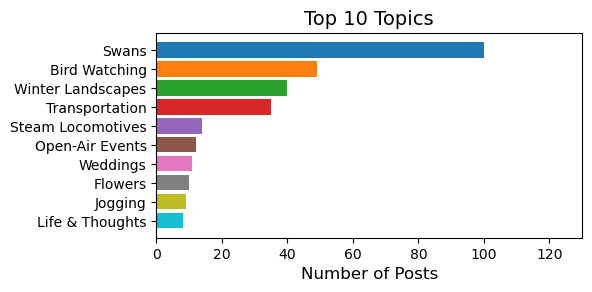
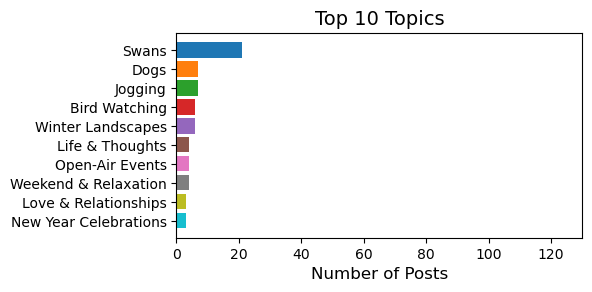
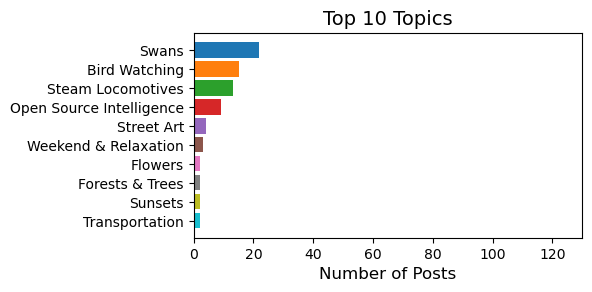
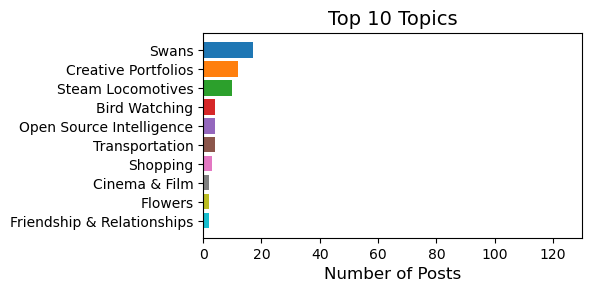
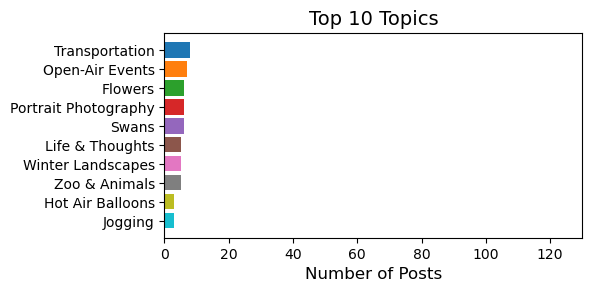
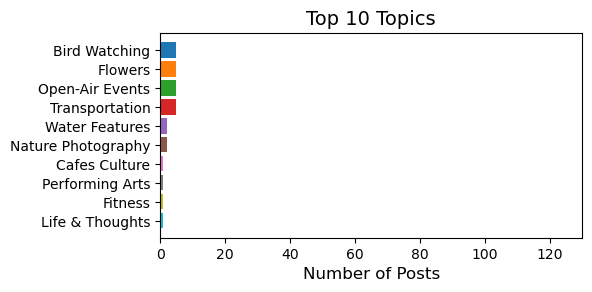
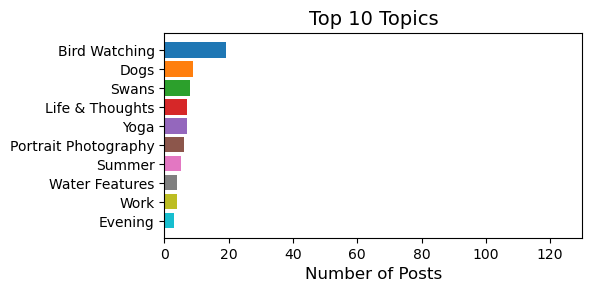
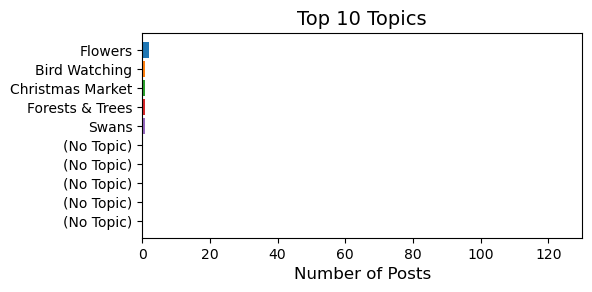
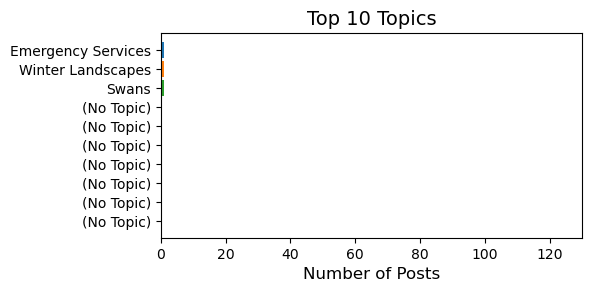
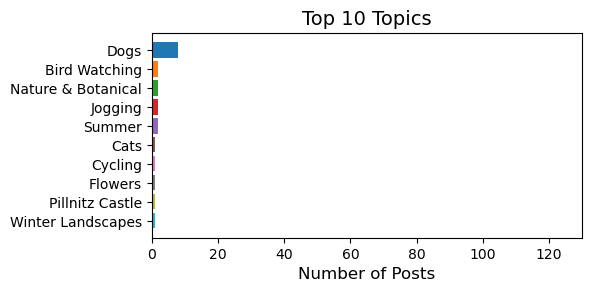
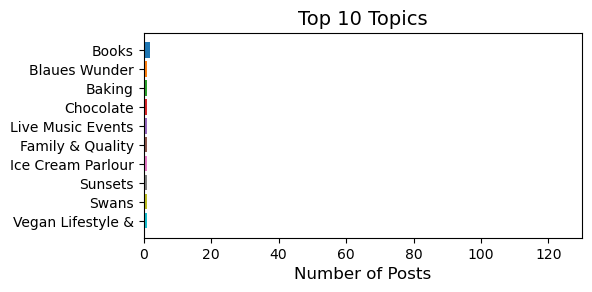
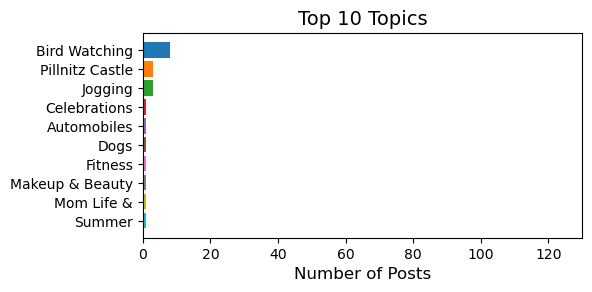
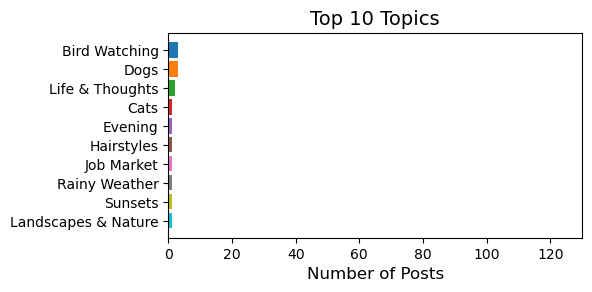
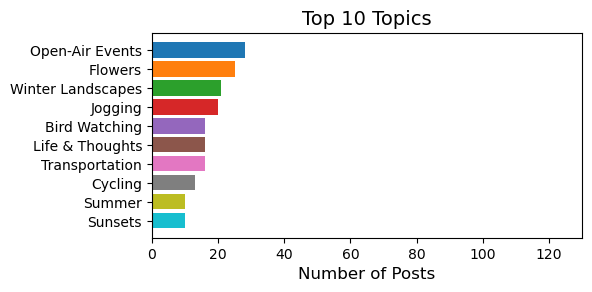
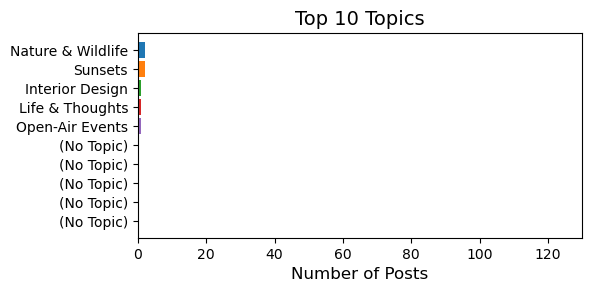
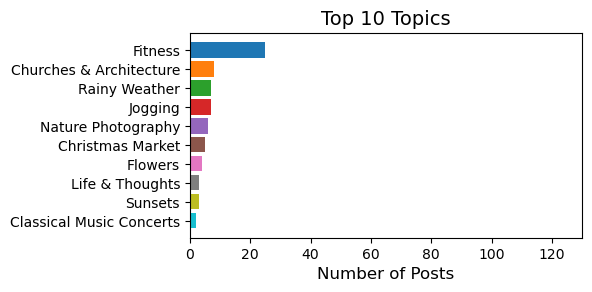
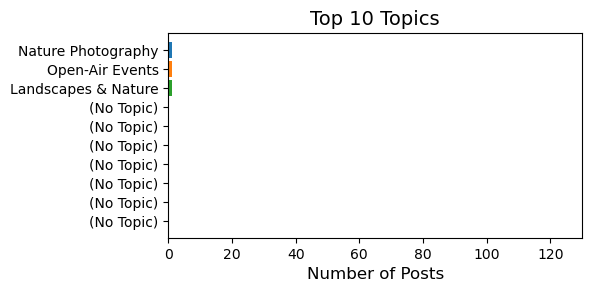
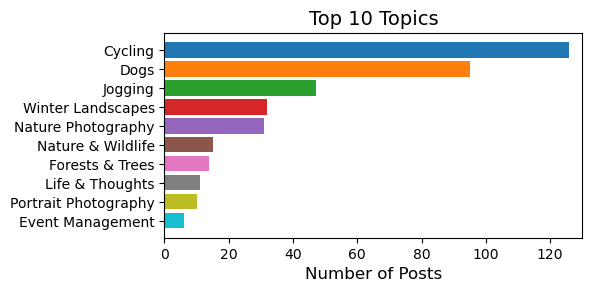
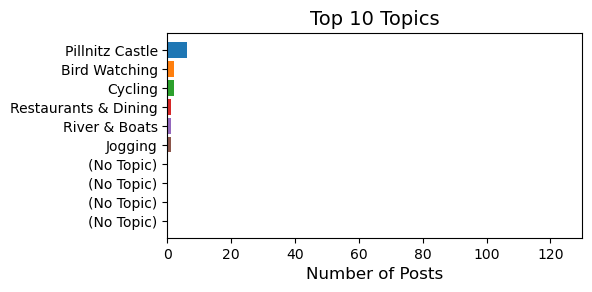
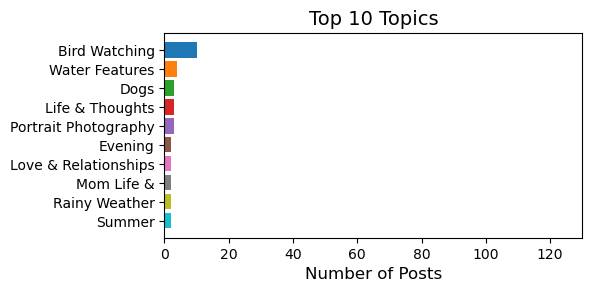
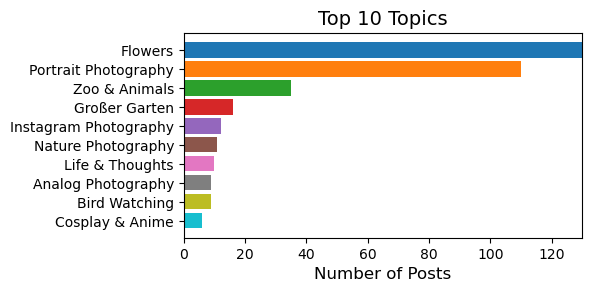

In [13]:
barcharts = generate_bar_charts_for_map(df, top_similar_h3_df, topic_column = 'T#_GTE1', topic_labels_column = 'Label',top_n=20)
map2 = visualize_similar_places_barcharts(df, target_h3_index, top_similar_h3_df, barcharts, top_n = 20)
map2.save(f"./03_Visualizations/Carolasee_Barcharts_ChiWeightedMeanPooling.html")
map2


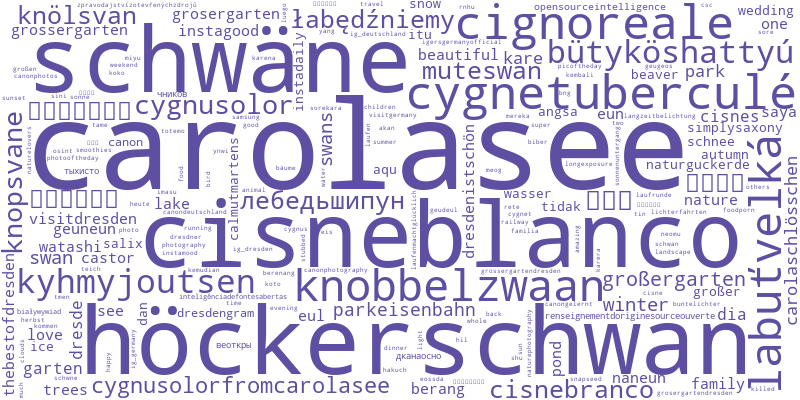
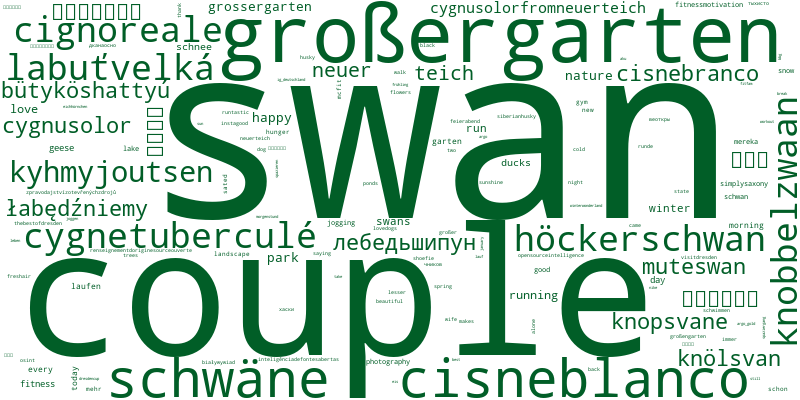
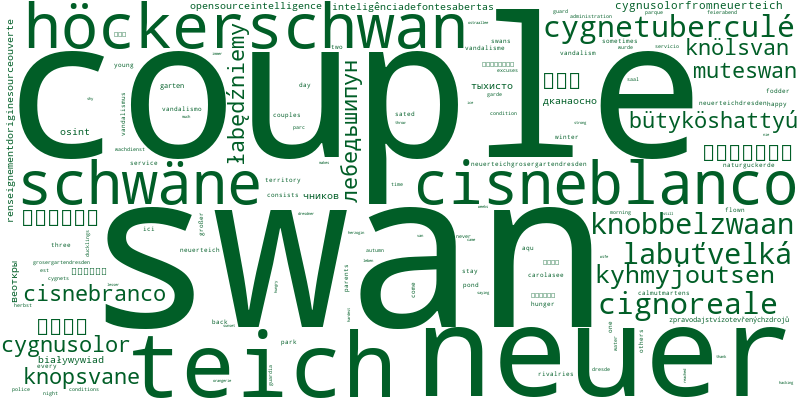
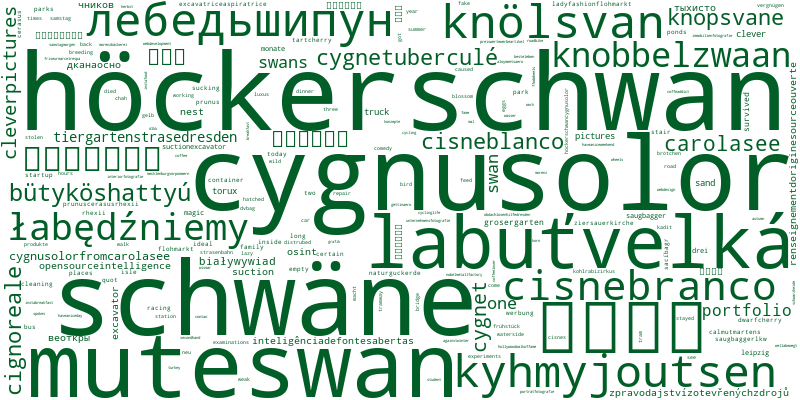
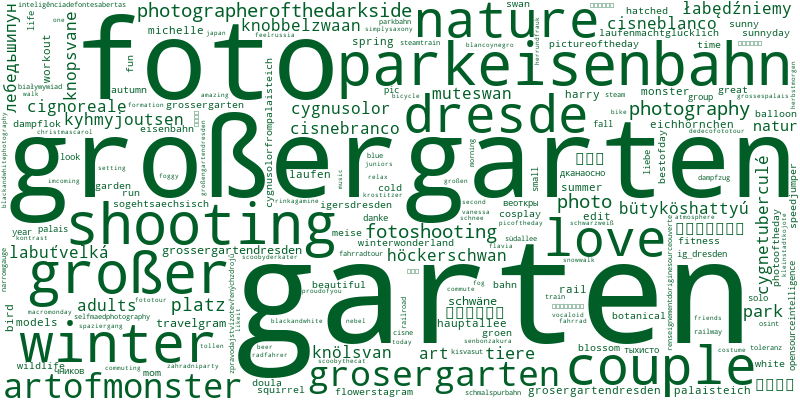
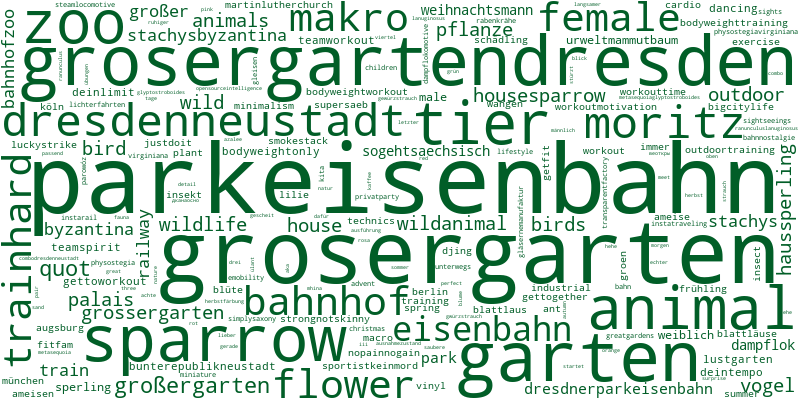
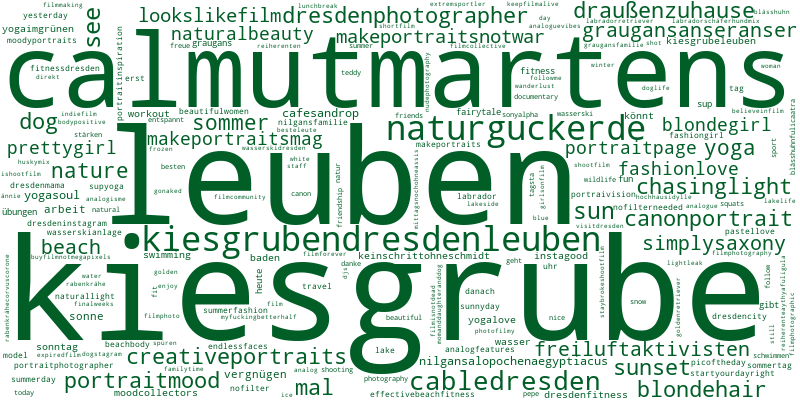
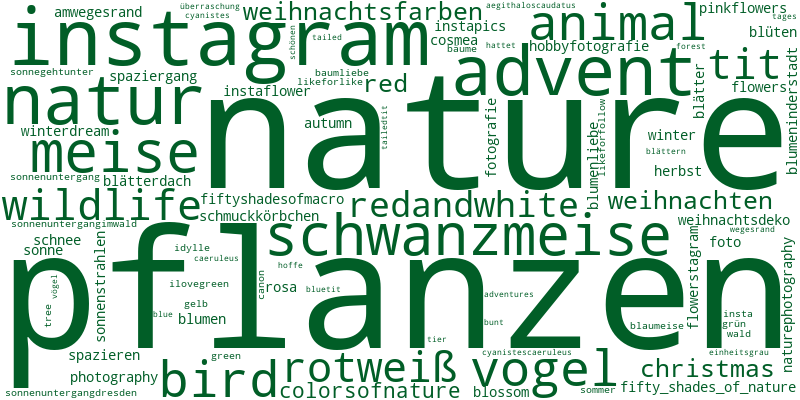
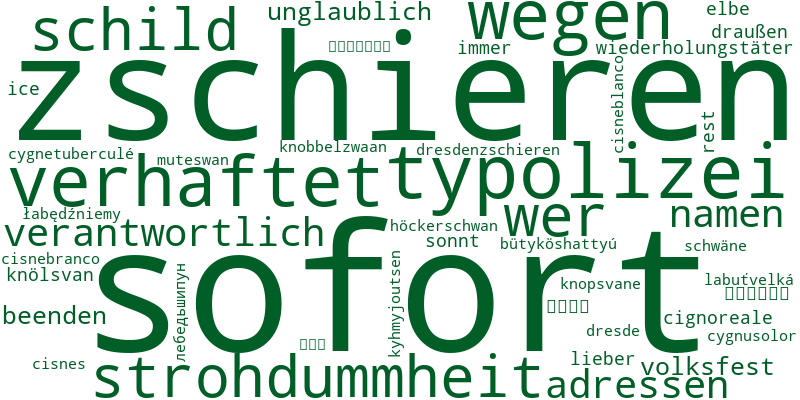
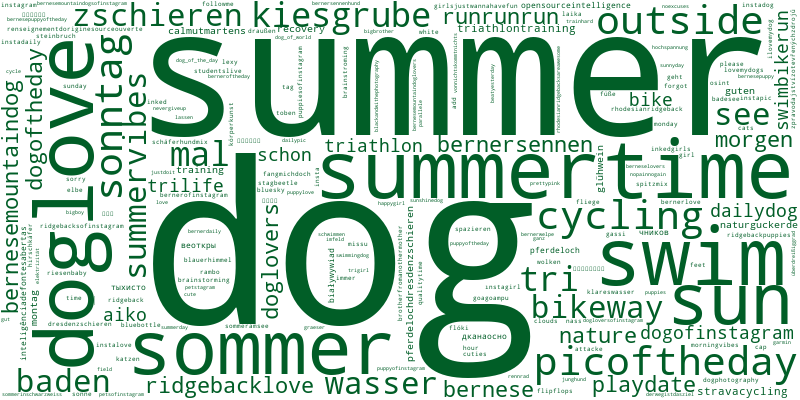
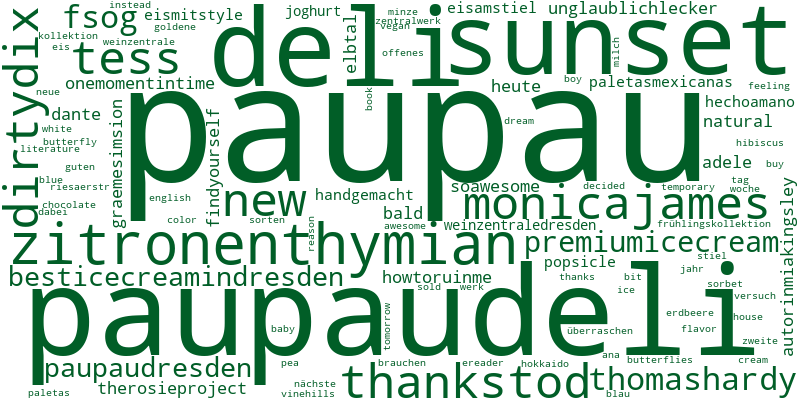
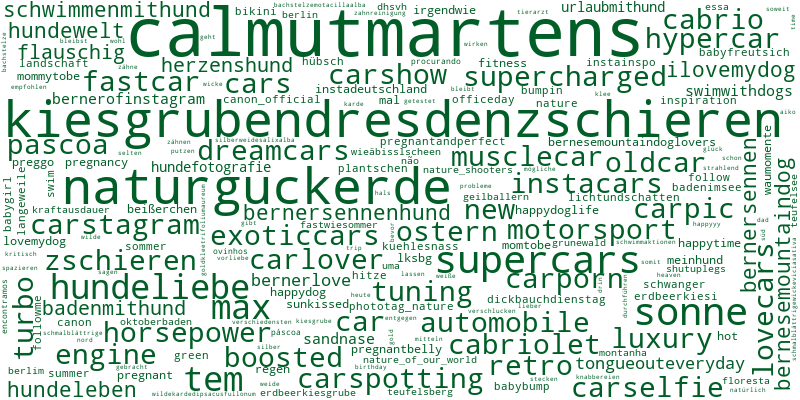
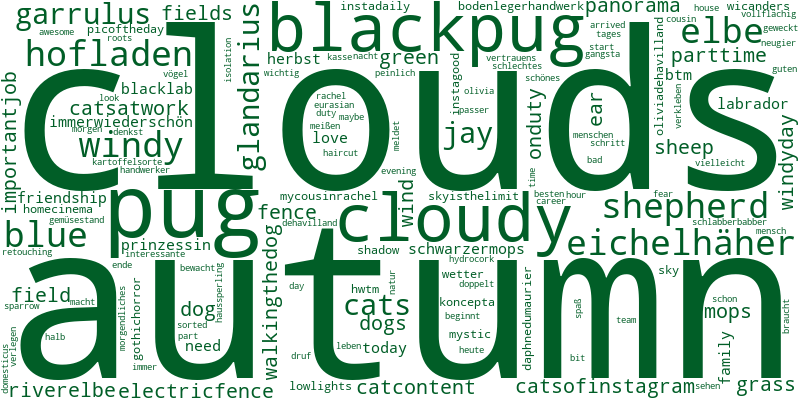
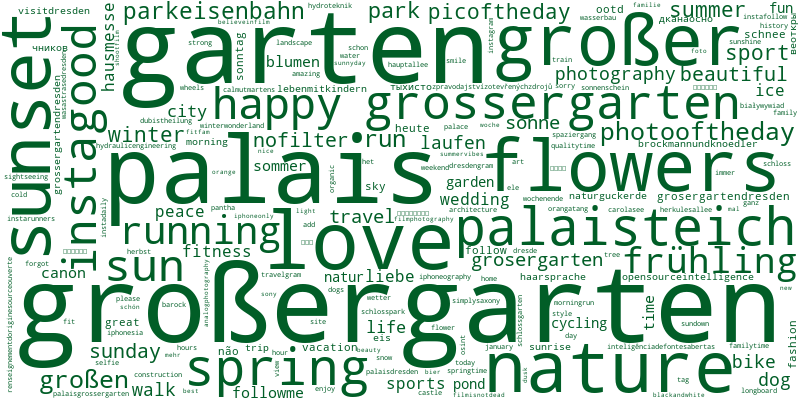
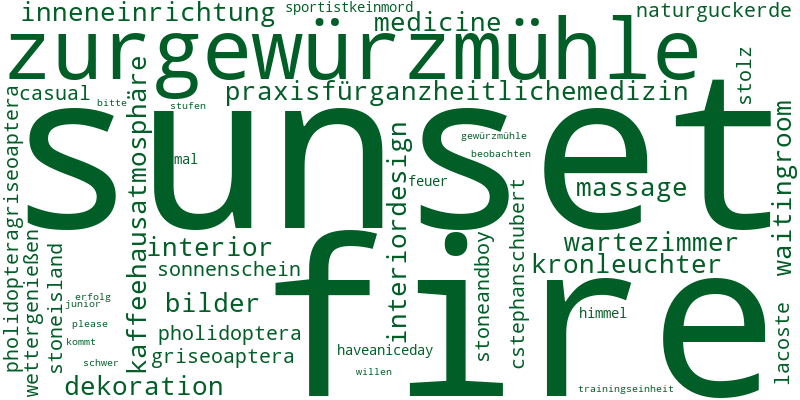
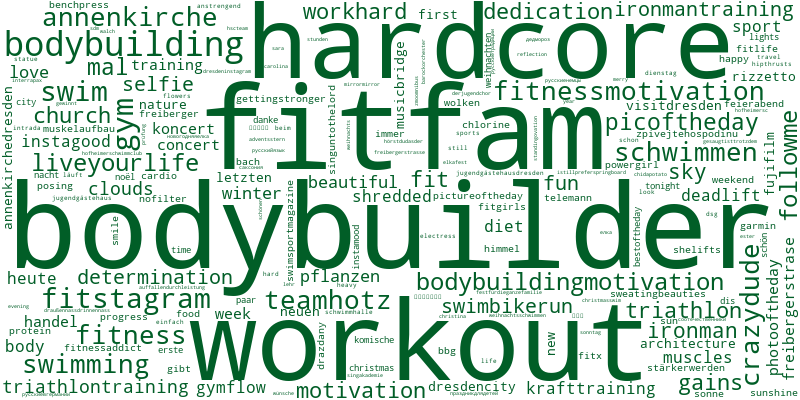
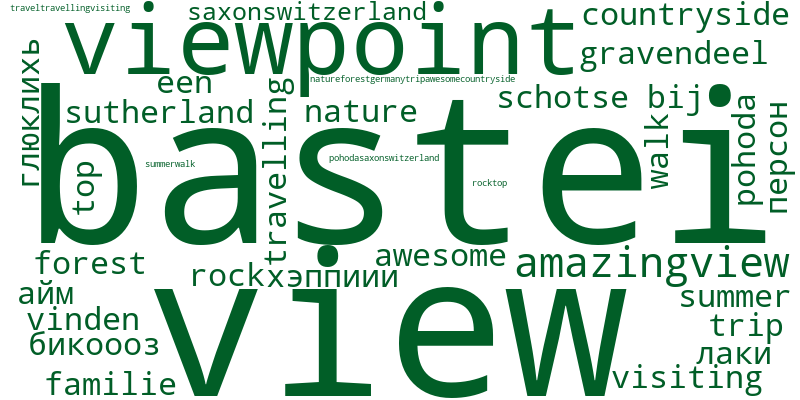
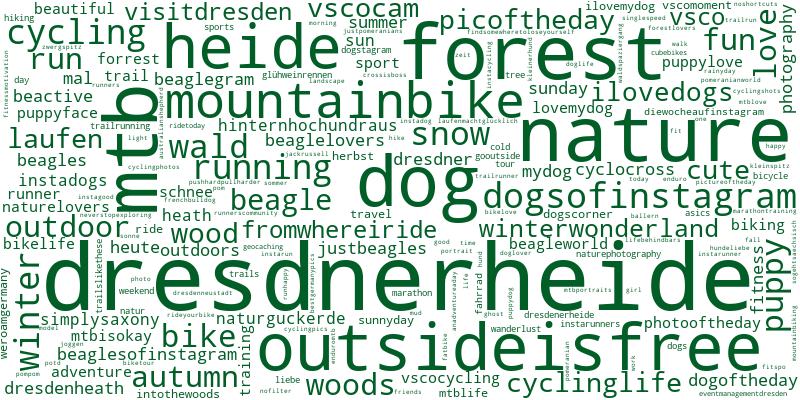
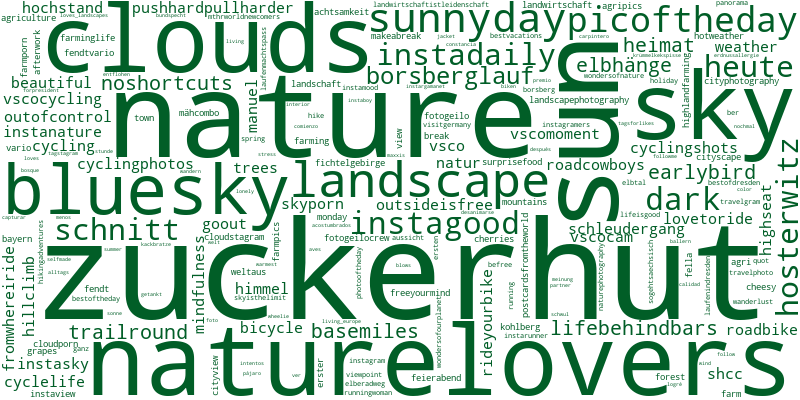
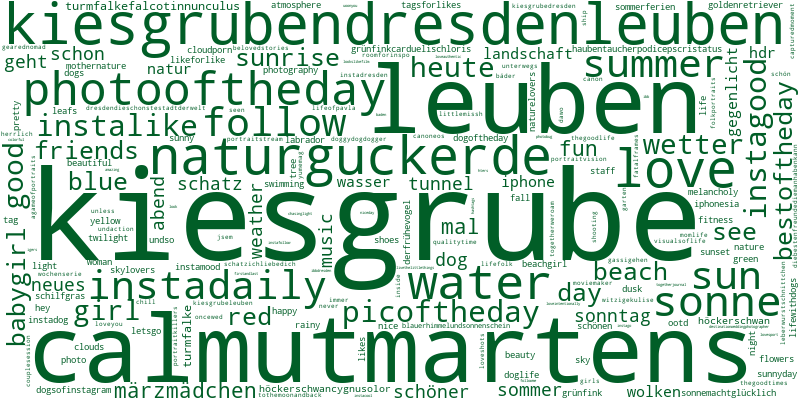
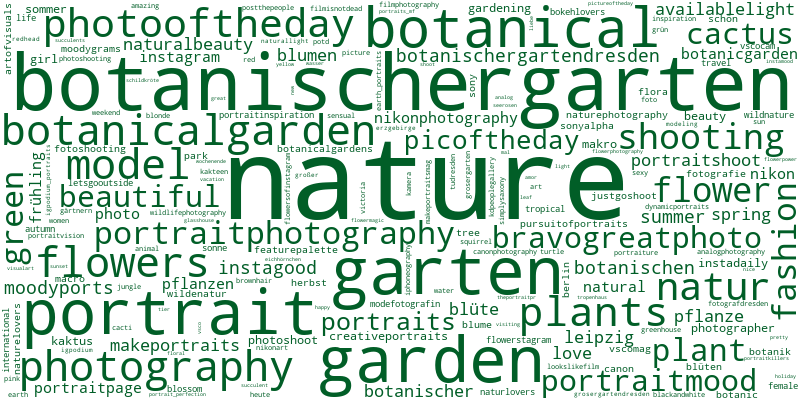

In [14]:
wordclouds = generate_wordclouds_for_map(df, top_similar_h3_df, text_column='tokens', top_n = 20)
map1 = visualize_similar_places_wordclouds(df, target_h3_index, top_similar_h3_df, wordclouds, top_n = 20)
map1.save(f"./03_Visualizations/Carolasee_Wordclouds_ChiWeightedMeanPooling.html")
map1

In [15]:
!jupyter nbconvert --to html "PlaceQueryDemo_PlaceBasedSemanticSearch.ipynb" --output "PlaceQueryDemo_PlaceBasedSemanticSearch.html"

[NbConvertApp] Converting notebook PlaceQueryDemo_PlaceBasedSemanticSearch.ipynb to html
[NbConvertApp] Writing 3237993 bytes to PlaceQueryDemo_PlaceBasedSemanticSearch.html
